In this task, you should train ResNet50 with pytorch using transfer learning to classify CIFAR10 dataset.

In [7]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor , Lambda
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.nn import Conv2d , Dropout , MaxPool2d
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
from time import time

# Load the dataset

Load the CIFAR10 dataset bellow. You can use either `torchvision.datasets.CIFAR10` or `sklearn.datasets.fetch_openml()` or any other way to load the dataset.

In [8]:
def load_data(train_transform=None,test_transform=None):
    trainset = datasets.CIFAR10(
        root="CIFAR10",
        train=True,
        download=True,
        transform=train_transform,
    )
    validset = datasets.CIFAR10(
        root="CIFAR10",
        train=False,
        download=True,
        transform=test_transform
    )
    train_loader = DataLoader(trainset,shuffle=True,batch_size=64)
    test_loader = DataLoader(validset,shuffle=True,batch_size=64)
    return train_loader , test_loader

In [9]:
train_transformer = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10,resample=False),
        transforms.Resize((150,150)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
test_transformer = transforms.Compose([
        transforms.Resize((150,150)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

train_loader , test_loader = load_data(train_transformer,test_transformer)


c:\Users\Morteza\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:1297: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed 0.14. Please use 'interpolation' instead.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


# Get ResNet34

Instantiate ResNet34 model (pretrained on imagenet) from `torchvision`'s model zoo.

In [10]:
# InceptionV3 = torchvision.models.inception_v3(pretrained=True,progress=True)

def create_pretrained():
    model = torchvision.models.resnet50(pretrained=True,progress=True)
    return model
model = create_pretrained()
model

c:\Users\Morteza\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\Morteza\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Modify for CIFAR10

Imagenet has 1000 classes, but CIFAR10 has 10. So, the decider layers of the model must be changed so that we can use the model for CIFAR10. Therefore, adapt `net.fc` and `net.AuxLogits.fc` with CIFAR10.

In [11]:
def modify_classifier(model,output_size=10):
    fc = nn.Linear(2048,output_size)
    return fc

def make_trainable(module):
    for param in module.parameters():
        param.requires_grad = True

# Freeze the convolutional part

In order to apply transfer learning, freeze all layers except the deciders. Freezing consist of disabling optimization by disabling grad calculation. Also in batch normalization layers, updating mooving average and variance must be disabled. Note that you must later filter out the frozen parameter for optimizer.

In [12]:
def make_no_grad(module):
    for param in module.parameters():
        param.requires_grad = False

# Instantiate the optimizer

Create the optimizer filtering out freezed parameters.

In [13]:
def instantiate_optimizer(model,lr=0.005,weight_decay=0.0001):
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
        weight_decay=weight_decay,
    )
    return optimizer

# Make change and Modify model base on writed function

In [14]:
def create_transfer_resnet(model):
    make_no_grad(model.conv1)
    make_no_grad(model.bn1)
    make_no_grad(model.maxpool)
    make_no_grad(model.layer1)
    make_no_grad(model.layer2)
    make_no_grad(model.layer3)
    make_no_grad(model.layer4)
    
    model.fc = modify_classifier(model)
    make_trainable(model.fc)
    
    def forward_impelementation(x):
        # in this part we pass x through the freeze layers
        with torch.no_grad():
            x = model.conv1(x)
            x = model.bn1(x)
            x = model.relu(x)
            x = model.maxpool(x)
            x = model.layer1(x)
            x = model.layer2(x)
            x = model.layer3(x)
            x = model.layer4(x)
            
        x = model.avgpool(x)
        x = torch.flatten(x, 1)
        x = model.fc(x)
        
        return x
    
    model.forward = forward_impelementation
    
    return model

# Train the model

Write your train/validation loop bellow. Then train the model until it converges. Feel free to add extra cells.

In [15]:
class Trainer(nn.Module):
    def __init__(self,trainloader,testloader,model):
        super(Trainer,self).__init__()
        self.trainloader = trainloader
        self.testloader = testloader
        self.model = model.cuda()
        self.optimizer = instantiate_optimizer(model=model,lr=0.005,weight_decay=0.0001)
        self.loss_fn = nn.CrossEntropyLoss()
        
    
    def forwrad(self,x):
        x = self.model(x)
        return x
  
  
    def evaluate(self,dataloader):
        self.eval()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        test_loss, correct = 0, 0
        with torch.no_grad():
            for X, y in dataloader:
                X = X.cuda()
                y = y.cuda()
                pred = self.model(X)
                test_loss += self.loss_fn(pred, y).item()
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        test_loss /= num_batches
        correct /= size
        return correct , test_loss

    def train_one_epoch(self,dataloader):
        self.train()
        size = len(dataloader.dataset)
        num_batches = len(dataloader)
        train_loss,correct = 0,0
        for batch, (X, y) in enumerate(dataloader):
          # Compute prediction and loss
          X = X.cuda()
          y = y.cuda()
          pred = self.model(X)

          # Backpropagation
          self.optimizer.zero_grad()
          self.loss_fn(pred,y).backward()
          self.optimizer.step()

        with torch.no_grad():
          for X,y in dataloader:
            X = X.cuda()
            y = y.cuda()
            pred = self.model(X)
            train_loss += self.loss_fn(pred,y).item()
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
            
        train_loss/=num_batches
        correct/=size
        return correct , train_loss

    def fit(self,epochs):
        train_acc = np.zeros(epochs)
        train_loss = np.zeros(epochs)
        test_acc = np.zeros(epochs)
        test_loss = np.zeros(epochs)
        for epoch in range(epochs):
            t1 = time()
            train_accuracy , train_cost = self.train_one_epoch(self.trainloader)
            test_accuracy , test_cost = self.evaluate(self.testloader)
            t2 = time()
            train_acc[epoch] = train_accuracy
            train_loss[epoch] = train_cost
            test_acc[epoch] = test_accuracy
            test_loss[epoch] = test_cost
            torch.save(model.state_dict({
                    "epochs":epochs,
                    "time":int(t2-t1),
                    "train_accuracy":train_acc,
                    "train_loss":train_loss,
                    "test_accuracy":test_acc,
                    "test_loss":test_loss
                }),f="ResNetPretrainedOnCifar10")
            print(f"Epoch {epoch+1} in Time {int(t2-t1)/60} minute, Train Accuracy: {(100*train_accuracy):>0.1f}%, Avg train loss: {train_cost:>8f} , Test Accuracy: {(100*test_accuracy):>0.1f}%, Avg test loss: {test_cost:>8f} \n")
        # save the model
        torch.save(model.state_dict(),f="ResNetPretrainedOnCifar10")
        return train_acc,train_loss,test_acc,test_loss


In [16]:
model = create_transfer_resnet(model=model)
trainer = Trainer(trainloader=train_loader,testloader=test_loader,model=model)
train_acc , train_loss , test_acc , test_loss = trainer.fit(epochs=20)

c:\Users\Morteza\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1365: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


Epoch 1 in Time 5.55 minute, Train Accuracy: 73.4%, Avg train loss: 0.804487 , Test Accuracy: 77.9%, Avg test loss: 0.677005 

Epoch 2 in Time 5.566666666666666 minute, Train Accuracy: 69.2%, Avg train loss: 1.015265 , Test Accuracy: 75.0%, Avg test loss: 0.834907 

Epoch 3 in Time 5.566666666666666 minute, Train Accuracy: 71.2%, Avg train loss: 0.918174 , Test Accuracy: 77.8%, Avg test loss: 0.720046 

Epoch 4 in Time 5.55 minute, Train Accuracy: 70.2%, Avg train loss: 0.973356 , Test Accuracy: 75.9%, Avg test loss: 0.826252 

Epoch 5 in Time 5.566666666666666 minute, Train Accuracy: 74.1%, Avg train loss: 0.847498 , Test Accuracy: 79.4%, Avg test loss: 0.681571 

Epoch 6 in Time 5.566666666666666 minute, Train Accuracy: 74.4%, Avg train loss: 0.842356 , Test Accuracy: 78.5%, Avg test loss: 0.758167 

Epoch 7 in Time 5.55 minute, Train Accuracy: 67.7%, Avg train loss: 1.241149 , Test Accuracy: 73.5%, Avg test loss: 1.039930 

Epoch 8 in Time 5.566666666666666 minute, Train Accuracy: 7

# Draw some images and prediction

In [43]:
def draw_images(images,labels,prediction):
    fig = plt.figure(figsize=(10,10))
    for i in range(10):
        ax = fig.add_subplot(4,5,i+1)
        # convert to image
        ax.imshow(images[i].permute(1,2,0).cpu().numpy())
        ax.set_title(f"Label: {labels[i]} \n Prediction: {prediction[i]}")
        ax.axis("off")
    plt.show()

# Draw the training curves

Draw two diagrams for train and validat
ion, one showing loss of each epoch, and another showing accuracy of each epoch.

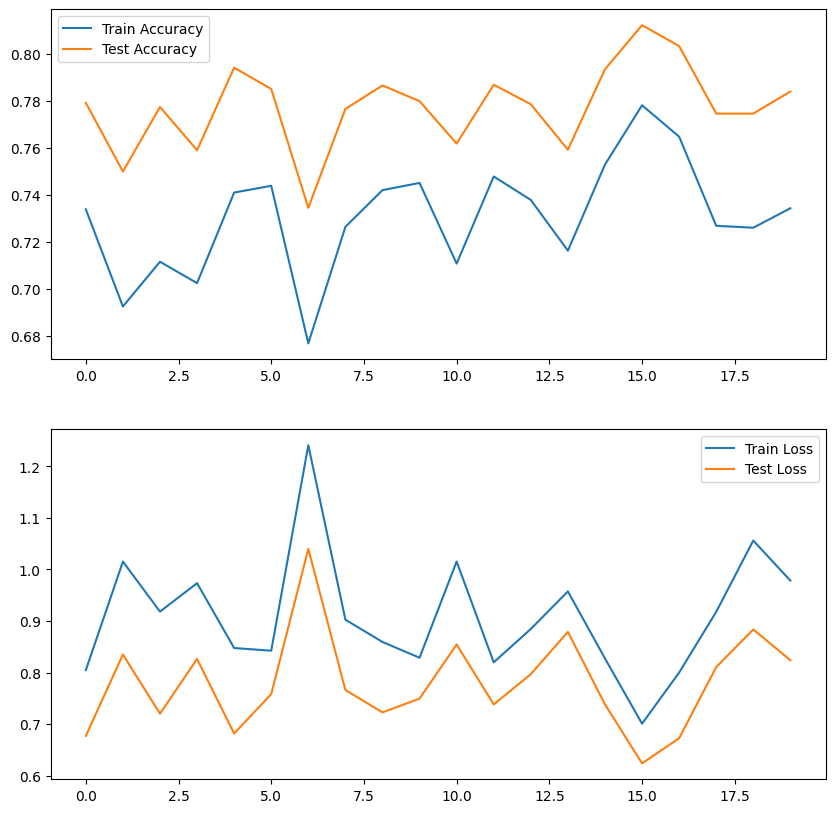

In [44]:
# draw the training curves
def draw_curves(train_acc,train_loss,test_acc,test_loss):
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(2,1,1)
    ax1.plot(train_acc,label="Train Accuracy")
    ax1.plot(test_acc,label="Test Accuracy")
    ax1.legend()
    ax2 = fig.add_subplot(2,1,2)
    ax2.plot(train_loss,label="Train Loss")
    ax2.plot(test_loss,label="Test Loss")
    ax2.legend()
    plt.show()

draw_curves(train_acc=train_acc,test_acc=test_acc,train_loss=train_loss,test_loss=test_loss)

# Evaluate your model

Evaluate the best epoch's model (according to the validation accuracy) on the test set, and report the accuracy. Is your model overfitted?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

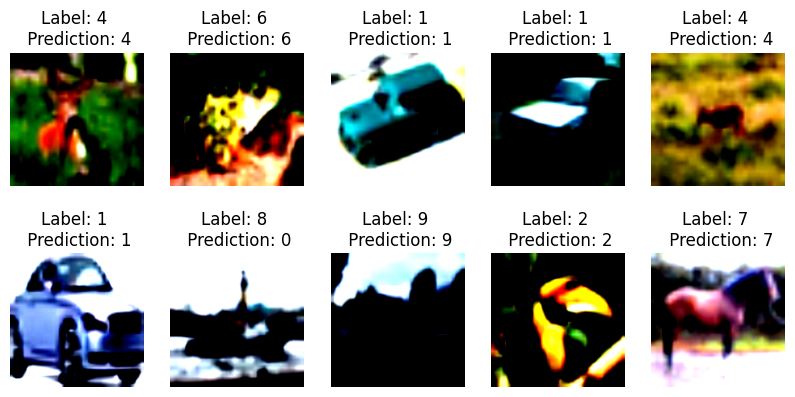

In [45]:
# evaluate model
def evaluate_model(model,testloader):
    model.eval()
    size = len(testloader.dataset)
    num_batches = len(testloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in testloader:
            X = X.cuda()
            y = y.cuda()
            pred = model(X)
            test_loss += nn.CrossEntropyLoss()(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Accuracy: {(100*correct):>0.1f}%, Avg test loss: {test_loss:>8f} \n")

# draw the images and prediction
images,labels = next(iter(test_loader))
images = images[:20]
labels = labels[:20]
images = images.cuda()
labels = labels.cuda()
prediction = model(images)
prediction = prediction.argmax(1)
draw_images(images,labels,prediction.cpu().numpy())


# Draw misclassified images

Draw 20 misclassified images from test set with expected and predicted labels.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

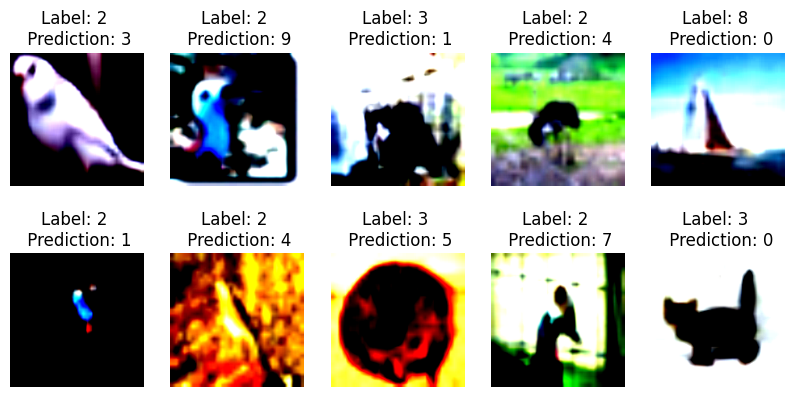

In [46]:
# draw misclassified images
def draw_misclassified_images(model,testloader):
    model.eval()
    size = len(testloader.dataset)
    num_batches = len(testloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in testloader:
            X = X.cuda()
            y = y.cuda()
            pred = model(X)
            test_loss += nn.CrossEntropyLoss()(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            prediction = pred.argmax(1)
            misclassified = (prediction!=y)
            images = X[misclassified]
            labels = y[misclassified]
            prediction = prediction[misclassified]
            draw_images(images,labels,prediction.cpu().numpy())
            break

draw_misclassified_images(model=model,testloader=test_loader)

# Plot the confusion matrix

Plot the confusion matrix for the test set.

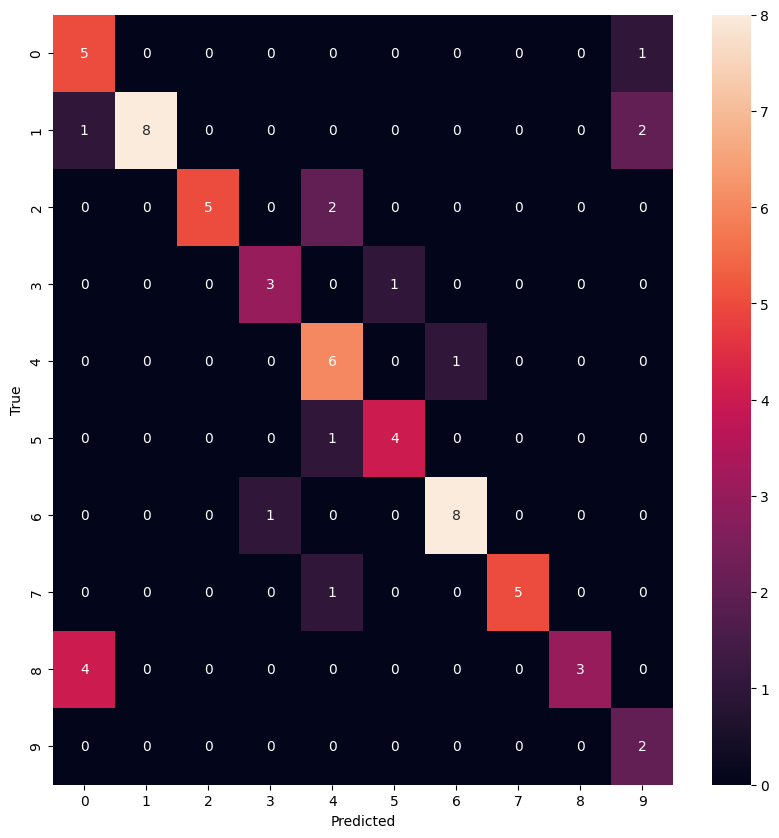

In [47]:
# plot the confusion matrix
from sklearn import metrics
import seaborn as sns

def plot_confusion_matrix(model,testloader):
    model.eval()
    size = len(testloader.dataset)
    num_batches = len(testloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in testloader:
            X = X.cuda()
            y = y.cuda()
            pred = model(X)
            test_loss += nn.CrossEntropyLoss()(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            prediction = pred.argmax(1)
            confusion_matrix = metrics.confusion_matrix(y.cpu().numpy(),prediction.cpu().numpy())
            plt.figure(figsize=(10,10))
            sns.heatmap(confusion_matrix,annot=True,fmt="d")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.show()
            break

plot_confusion_matrix(model=model,testloader=test_loader)